# Demo: plotting whisker positions

----

This is a step-by-step demonstration of:

1. How to retrieve a set of whisker positions from a trial object.
2. The way we perform baseline correction.
3. How to plot in the way we show in Figure 1.

Dependencies:

- Python 3.5+
- Numpy
- Pandas
- Matplotlib


**NOTE**: you need to get content of the `04_formatted` data repository populated beforehand, via:

```
$ cd ../01_data/04_formatted
$ gin init
$ find . -name "*.csv" | xargs gin get-content
```

In [1]:
from pathlib import Path
import math
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import datareader

In [2]:
dataroot = Path("../01_data/04_formatted")
colors   = dict(left="green", right="crimson")

In [3]:
trials = datareader.load_trials(dataroot)

## 1. Plotting a trial

### 1-a. Obtaining whisker positions (in degrees)

In [4]:
# first, we pick up an arbitrary trial

subject  = "MLA005757"
session  = "session2019-07-15-001"
index    = 2

matched  = [trial for trial in trials if trial.subject == subject and trial.session == session and trial.index == index]

trial = matched[0]
trial_time = np.arange(trial.tracking.shape[0]) / 200 # 200 Hz acquisition rate

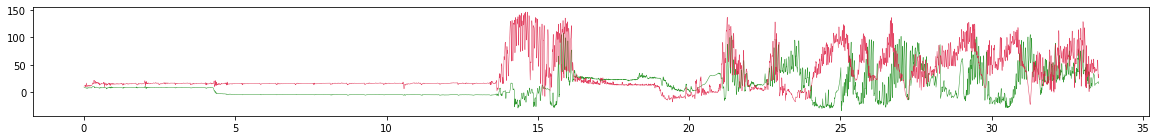

In [5]:
fig, ax = plt.subplots(1,1,figsize=(20,2))

for side in ("left", "right"):
    ax.plot(trial_time, trial.tracking[f"{side}_whisker_angle_deg"], lw=0.5, color=colors[side], alpha=0.8)
plt.show()

### 1-b. Baseline correction

In [6]:
def get_baseline_position(states, positions, method=np.nanmean):
    motion_began = states[states.State == "Backward"].FromFrame.min()
    used_rows = states[np.logical_and(states.ToFrame < motion_began,
                                           states.State == "AtEnd")]
    def _pick(row, pos):
        return pos[(row.FromFrame-1):(row.ToFrame)]
    
    pos_used = np.concatenate([_pick(used_rows.iloc[i], positions) for i in range(used_rows.shape[0])])
    return method(pos_used)

In [7]:
baselines = dict((side, get_baseline_position(trial.states, trial.tracking[f"{side}_whisker_angle_deg"])) \
                for side in ("left", "right"))

baselines

{'left': 6.6792381749824905, 'right': 23.13277751797975}

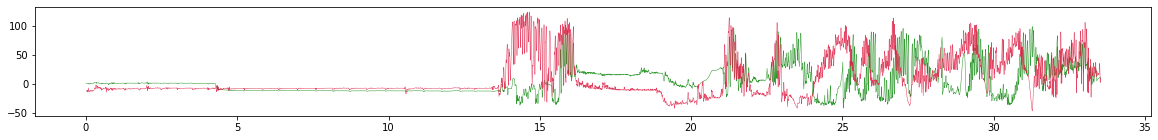

In [8]:
fig, ax = plt.subplots(1,1,figsize=(20,2))

for side in ("left", "right"):
    pos = trial.tracking[f"{side}_whisker_angle_deg"] - baselines[side]
    ax.plot(trial_time, pos, lw=0.5, color=colors[side], alpha=0.8)
plt.show()

### 1-c. State annotation

In [9]:
from matplotlib.patches import Rectangle

state_colors = {
    "AtEnd":      "black",
    "AtCenter":   "gray",
    "AtMidpoint": "gray",
    "Groom":      "white",
    "Backward":   "orange",
    "Left":       "green",
    "Right":      "magenta",
    "Forward":    "dodgerblue",
    "Expect":     "navy",
    "Lick":       "purple"
}

In [10]:
def get_annotation(row, time, time_baseline=0, pos_baseline=350, thickness=30, colors=state_colors):
    from_time = time[row.FromFrame-1] - time_baseline
    to_time   = time[min(row.ToFrame-1, time.size-1)] - time_baseline
    return Rectangle((from_time, pos_baseline), to_time - from_time, thickness, 
                     facecolor=colors[row.State], edgecolor="white")

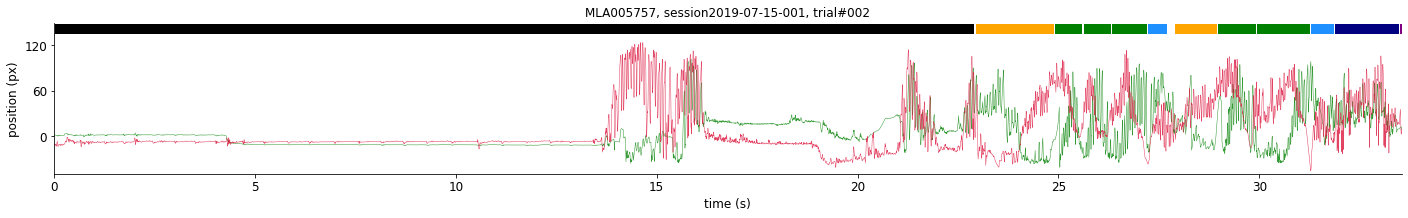

In [11]:
anno_thickness = 15
xlim           = (trial_time.min(), trial_time.max())
ylim           = (-50, 150)
yticks         = (0, 60, 120)
label_size     = 12
fig_height     = 3.5

fig, ax = plt.subplots(1,1,figsize=(trial_time.max()*0.6, fig_height))
for side in ("left", "right"):
    pos = trial.tracking[f"{side}_whisker_angle_deg"] - baselines[side]
    ax.plot(trial_time, pos, lw=0.5, color=colors[side], alpha=0.8)
    
for rowidx in range(trial.states.shape[0]):
    row = trial.states.iloc[rowidx]
    plt.gca().add_patch(get_annotation(row, trial_time, 
                                       pos_baseline=ylim[1]-anno_thickness, thickness=anno_thickness))

plt.xlim(xlim)
plt.ylim(ylim)
plt.yticks(yticks)

for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.title(f"{trial.subject}, {trial.session}, trial#{trial.index:03d}", fontsize=label_size)
plt.xlabel("time (s)", fontsize=label_size)
plt.ylabel("position (px)", fontsize=label_size)
plt.tick_params(labelsize=label_size)
plt.subplots_adjust(bottom=0.2, left=0.05, right=0.98, top=0.8)